<a href="https://colab.research.google.com/github/shagufta24/brain_tumor_detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection in MRI Scans 🧠
Using Computer Vision for binary classification of MRI scan images.

## Setup

In [1]:
!pip install albumentations

In [2]:
import os
import random
import shutil
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Image processing
import cv2
from PIL import Image

# Deep learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling2D, Input, MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

# Data augmentation
import albumentations as A
from albumentations.core.composition import OneOf

# Metrics and model evaluation
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

# Progress bar
from tqdm import tqdm

In [3]:
# Set random seed for reproducibility
random.seed(42)

In [4]:
import kagglehub
kagglehub.login()

# KAGGLE_USERNAME=shaguftaanjum
# KAGGLE_KEY=5d4eccb18cc0091862b63282dfafcd64

Kaggle credentials set.
Kaggle credentials successfully validated.


## Dataset Loading

### About the dataset:
The **Brain MRI dataset for tumor detection** from Kaggle ([Dataset Link](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)) consists of MRI images of brains classified into two categories:  
- `'yes'` (presence of a brain tumor)  
- `'no'` (absence of a brain tumor)



In [5]:
# Download and extract dataset
download_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

100%|██████████| 15.1M/15.1M [00:00<00:00, 32.6MB/s]

Extracting files...


We create a directory structure suitable for machine learning tasks, dividing the dataset into three subsets:
- `train` (80%): used for model training  
- `val` (10%): used for model validation during training  
- `test` (10%): used for final evaluation of the trained model  

In [6]:
# Destination directories
BASE_DEST = '/content/dataset'
TRAIN_DIR = os.path.join(BASE_DEST, 'train')
VAL_DIR = os.path.join(BASE_DEST, 'val')
TEST_DIR = os.path.join(BASE_DEST, 'test')

# Create directory structure
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in ['yes', 'no']:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)


Data Shuffling and Splitting:
- Images are randomly shuffled within each class (`yes` and `no`) to ensure a balanced and unbiased split across train, validation, and test sets.
- Images are then distributed into their respective directories according to predefined ratios.

In [7]:
# Organize the data
IMG_PATH = download_path + '/brain_tumor_dataset'

# Loop through each class folder in downloaded dataset
for CLASS in os.listdir(IMG_PATH):
    if CLASS.startswith('.'):
        continue  # skip hidden files/folders

    class_path = os.path.join(IMG_PATH, CLASS)
    img_files = os.listdir(class_path)

    # Shuffle files for randomness
    random.shuffle(img_files)

    # Total number of images in this class
    IMG_NUM = len(img_files)

    test_ratio = 0.1  # 10% test
    val_ratio = 0.1   # 10% validation
    train_ratio = 1 - test_ratio - val_ratio  # 80% train

    for n, FILE_NAME in enumerate(img_files):
        img_full_path = os.path.join(class_path, FILE_NAME)

        if n < val_ratio * IMG_NUM:
            dest_folder = os.path.join(VAL_DIR, CLASS)
        elif n < (test_ratio + train_ratio) * IMG_NUM:
            dest_folder = os.path.join(TRAIN_DIR, CLASS)
        else:
            dest_folder = os.path.join(TEST_DIR, CLASS)

        # Copy image to destination folder
        shutil.copy(img_full_path, os.path.join(dest_folder, FILE_NAME))

The `load_data()` function loads images from the dataset directories.  
Each image is:
- Read using OpenCV (`cv2`).
- Converted from BGR to RGB format.
- Resized to `(224, 224)` to match the input size required by VGG16 model (applied later).


In [8]:
IMG_SIZE = (224, 224)  # Resize images to this size
CLASS_NAMES = ['no', 'yes']  # 'no' -> 0, 'yes' -> 1

def load_data(data_dir):
    X = []
    y = []

    # Loop over each class
    for label, class_name in enumerate(CLASS_NAMES):
        class_folder = os.path.join(data_dir, class_name)

        # Loop over each image in the class folder
        for file_name in os.listdir(class_folder):
            if file_name.startswith('.'):
                continue  # skip hidden files/folders

            img_path = os.path.join(class_folder, file_name)

            # Read image
            img = cv2.imread(img_path)

            # Convert BGR to RGB (cv2 reads as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image
            img = cv2.resize(img, IMG_SIZE)

            X.append(img)
            y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    return X, y

# Load train, val, and test datasets
X_train, y_train = load_data(TRAIN_DIR)
X_val, y_val = load_data(VAL_DIR)
X_test, y_test = load_data(TEST_DIR)

print(f"Train data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Train data shape: (203, 224, 224, 3), Labels shape: (203,)
Validation data shape: (26, 224, 224, 3), Labels shape: (26,)
Test data shape: (24, 224, 224, 3), Labels shape: (24,)


## Analyze data

### Class Distribution

We analyze and visualize the **class distribution** of the dataset across the **train**, **validation**, and **test** splits to identify any class imbalance and consider it during model training. Class imbalances can be later corrected using techniques like **data augmentation** or **resampling**.



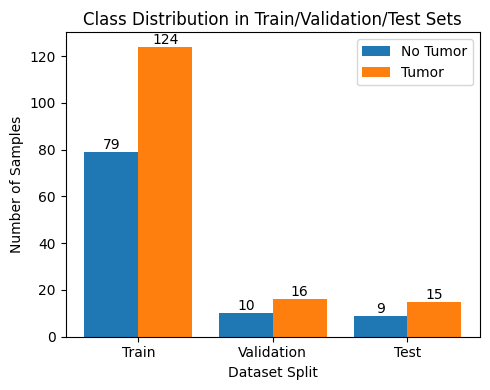

In [9]:
# Get class counts
def get_class_distribution(y, class_names):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip([class_names[i] for i in unique], counts))

# Get distributions
train_dist = get_class_distribution(y_train, CLASS_NAMES)
val_dist = get_class_distribution(y_val, CLASS_NAMES)
test_dist = get_class_distribution(y_test, CLASS_NAMES)

# Prepare data for plotting
sets = ['Train', 'Validation', 'Test']
no_counts = [train_dist.get('no', 0), val_dist.get('no', 0), test_dist.get('no', 0)]
yes_counts = [train_dist.get('yes', 0), val_dist.get('yes', 0), test_dist.get('yes', 0)]

# Plotting
x = np.arange(len(sets))  # the label locations
width = 0.4  # width of the bars

fig, ax = plt.subplots(figsize=(5, 4))

bars1 = ax.bar(x - width/2, no_counts, width, label='No Tumor')
bars2 = ax.bar(x + width/2, yes_counts, width, label='Tumor')

# Labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution in Train/Validation/Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(sets)
ax.legend()

# Add counts on top of bars
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_counts(bars1)
add_counts(bars2)

plt.tight_layout()
plt.show()

### Visualize sample images

We visualize some sample of images from each class label to confirm that the **data preprocessing steps** (such as resizing, color conversion) have been applied properly, and the dataset contains **meaningful and relevant features** for the classification task.


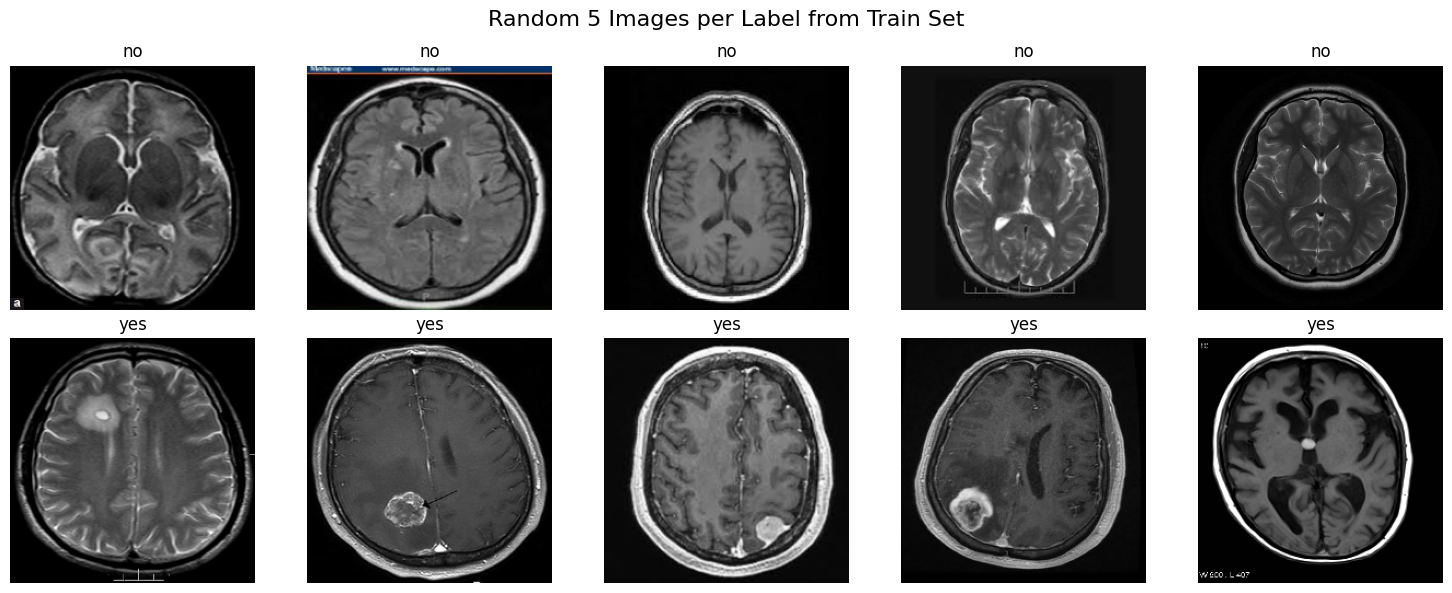

In [10]:
def plot_random_images_per_label(X, y, class_names=CLASS_NAMES, num_images=5, dataset_name='Dataset'):
    plt.figure(figsize=(num_images * 3, len(class_names) * 3))

    for label_idx, label_name in enumerate(class_names):
        # Get indices of images belonging to this label
        label_indices = np.where(y == label_idx)[0]

        # If less images available than num_images, adjust
        n_select = min(num_images, len(label_indices))

        # Randomly select image indices
        selected_indices = random.sample(list(label_indices), n_select)

        for i, img_idx in enumerate(selected_indices):
            plt.subplot(len(class_names), num_images, label_idx * num_images + i + 1)
            plt.imshow(X[img_idx].astype(np.uint8))
            plt.title(f"{label_name}")
            plt.axis('off')

    plt.suptitle(f'Random {num_images} Images per Label from {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_random_images_per_label(X_train, y_train, dataset_name='Train Set')


## Preprocess data

### Cropping the Brain Region from MRI Images

MRI images often have **variable dimensions** and **unused areas** (black regions or padding) that do not contribute useful information for tumor detection.
Simply resizing such images can **distort** them, affecting the model's ability to learn relevant features. Cropping ensures that the **brain occupies most of the image space**, leading to better learning and improved model performance.

This step improves the quality of the dataset by:
- Focusing on the **region of interest** (the brain).
- Removing **irrelevant background areas** (e.g., black corners), which can introduce noise.
- Ensuring better **consistency** when resizing images for input into deep learning models which expect input images of fixed size.

#### Steps:
- **Convert to Grayscale**: Simplifies the image by removing color information, making it easier to detect contours.
- **Apply Gaussian Blur**: Smoothens the image and reduces noise, which helps in accurate thresholding.
- **Thresholding**: Converts the grayscale image into a binary image, separating the brain region from the background.
- **Morphological Operations**: **Erosion** and **Dilation** clean up the binary image by removing small noise and filling gaps.
- **Find Contours**: Detects the boundaries of objects in the binary image.
- **Select the Largest Contour**: Assumes the largest contour represents the brain.
- **Get Bounding Box**: Calculates the rectangular region that tightly encloses the brain.


In [11]:
def crop_brain_region(image, size):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding to get the binary mask
    # Convert the image to uint8 before thresholding
    gray = gray.astype(np.uint8) # Changed line
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours found, return resized original image (to avoid crash)
    if len(contours) == 0:
        return image, image, image, cv2.resize(image, size)

    # Largest contour is assumed to be the brain
    c = max(contours, key=cv2.contourArea)

    # Get bounding box
    x, y, w, h = cv2.boundingRect(c)

    # Draw contours/bounding boxes (for visualization)
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop and resize
    cropped_image = image[y:y + h, x:x + w]
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

Visualization of the cropping process:
  - `contour_image`: Image showing the detected contour.
  - `bounding_box_image`: Image showing the bounding box around the brain.

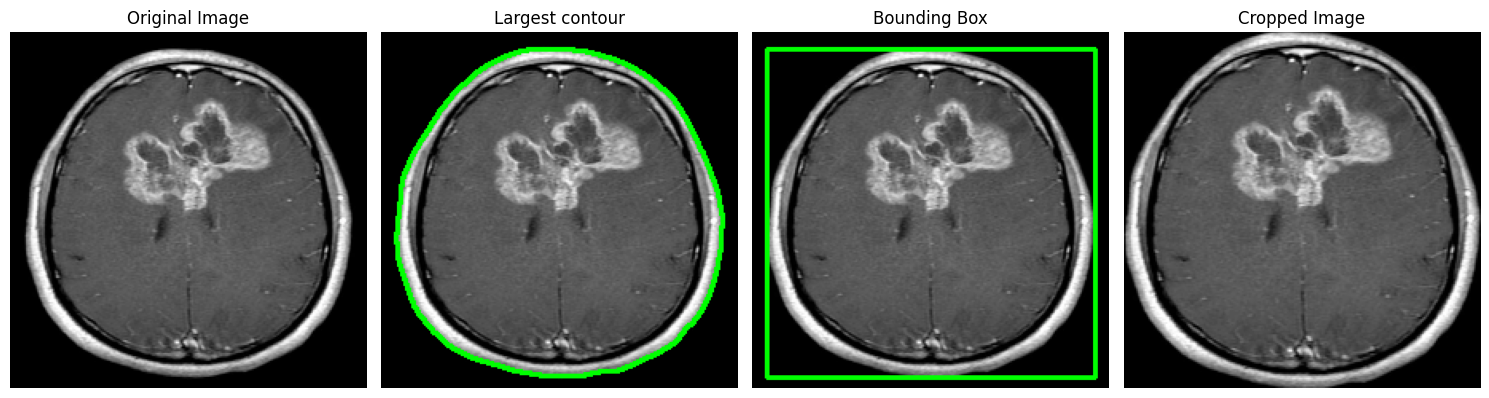

In [12]:
# Select a random image and label from the training set
rand_idx = random.randint(0, len(X_train) - 1)
random_image = X_train[rand_idx]
random_label = y_train[rand_idx]

# Apply the crop_brain_region function to get intermediate outputs
contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(random_image, (224, 224))

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(random_image.astype(np.uint8))
plt.title(f"Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(contour_image.astype(np.uint8))
plt.title("Largest contour")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(bounding_box_image.astype(np.uint8))
plt.title("Bounding Box")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cropped_image.astype(np.uint8))
plt.title("Cropped Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
def crop_images(X, y, dataset_name, output_base_path, output_size=(224, 224)):
    """
    X: images
    y: labels (0 for 'no', 1 for 'yes')
    dataset_name: 'train', 'val', 'test'
    output_base_path: where to save cropped datasets, e.g. './dataset'
    output_size: resized output image size
    """
    # Define output folder structure
    output_folder = os.path.join(output_base_path, f"{dataset_name}_cropped")

    cropped_images = []

    # Create directories for 'yes' and 'no'
    for class_name in CLASS_NAMES:  # ['no', 'yes']
        class_folder = os.path.join(output_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)

    print(f"Saving cropped images to: {output_folder}")

    # Iterate over images and labels
    for idx, (image, label) in enumerate(zip(X, y)):
        # Crop and resize the brain region
        _, _, _, resized_image = crop_brain_region(image, output_size)
        cropped_images.append(resized_image)

        class_name = CLASS_NAMES[label]

        # File path to save
        save_folder = os.path.join(output_folder, class_name)
        save_filename = f"{dataset_name}_{class_name}_{idx}.jpg"
        save_path = os.path.join(save_folder, save_filename)

        # Convert image from RGB to BGR for cv2.imwrite
        resized_image_bgr = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, resized_image_bgr)
    return np.array(cropped_images, dtype=np.float32)

Apply cropping operation to the entire dataset

In [14]:
X_train_cropped = crop_images(X_train, y_train, 'train', BASE_DEST, output_size=(224, 224))
X_val_cropped = crop_images(X_val, y_val, 'val', BASE_DEST, output_size=(224, 224))
X_test_cropped = crop_images(X_test, y_test, 'test', BASE_DEST, output_size=(224, 224))

print(f"Cropped Train Shape: {X_train_cropped.shape}")
print(f"Cropped Val Shape: {X_val_cropped.shape}")
print(f"Cropped Test Shape: {X_test_cropped.shape}")

Saving cropped images to: /content/dataset/train_cropped
Saving cropped images to: /content/dataset/val_cropped
Saving cropped images to: /content/dataset/test_cropped
Cropped Train Shape: (203, 224, 224, 3)
Cropped Val Shape: (26, 224, 224, 3)
Cropped Test Shape: (24, 224, 224, 3)


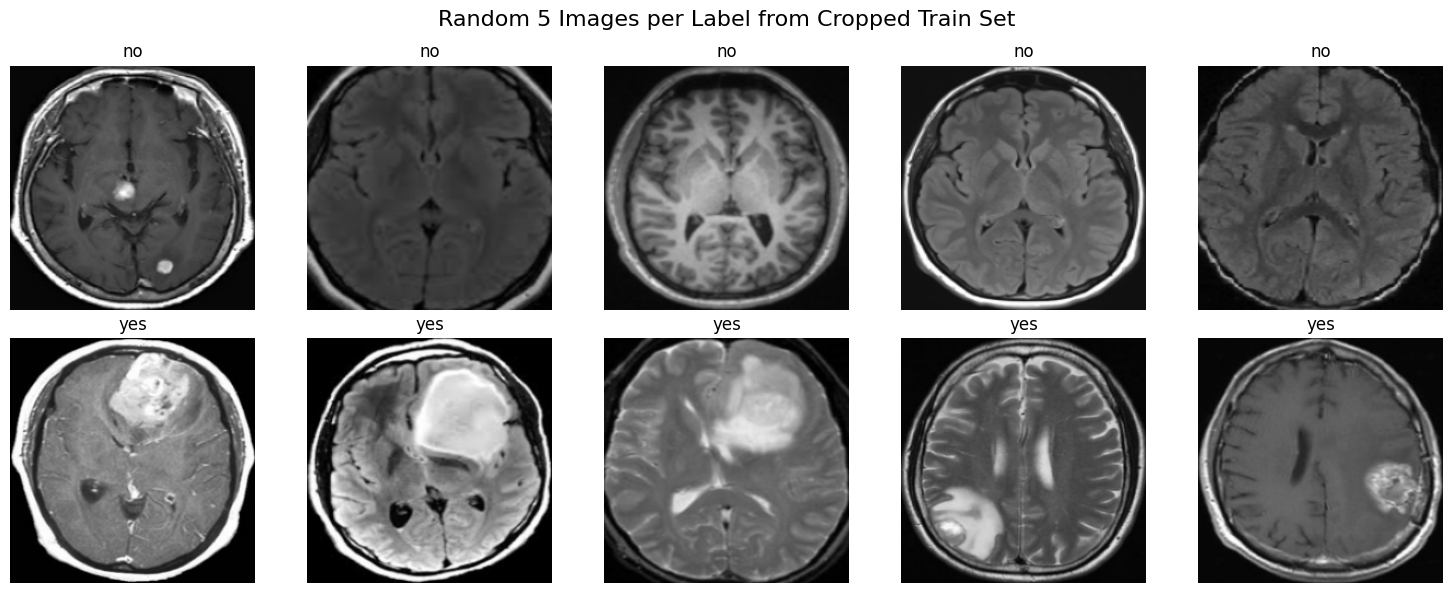

In [15]:
plot_random_images_per_label(X_train_cropped, y_train, dataset_name='Cropped Train Set')

### Data Augmentation

We define an augmentation pipeline using the `albumentations` library to artificially increase the diversity of our training dataset. Augmentation helps improve the robustness and generalization of models by creating variations of existing images.  
This is especially important when working with small datasets like this one, as it helps to increase dataset size without collecting new data, preventing overfitting during training.

#### Augmentations Applied:
- `HorizontalFlip(p=0.5)`: Randomly flips the image horizontally with a **50%** chance.
- `VerticalFlip(p=0.1)`: Randomly flips the image vertically with a **10%** chance.
- `RandomRotate90(p=0.5)`: Rotates the image by 90 degrees, **randomly** applied with a **50%** probability.
- `Affine`: Applies **affine transformations** including:
  - Scaling by a random factor between **0.9x and 1.1x**.
  - Translating (shifting) by up to **10%** of the image size.
  - Rotating between **-15 and 15 degrees**.
  - Shearing between **-10 and 10 degrees**.
- `RandomBrightnessContrast(p=0.5)`: Randomly changes brightness and contrast with a **50%** chance.
- `ElasticTransform`: Applies random **elastic distortions** to simulate tissue deformations in MRI scans:
  - `alpha` and `sigma` control the strength and smoothness of the transformation.
  - Applied with a **20%** chance.
- `GaussNoise(p=0.2)`: Adds random **Gaussian noise** to the image with a **20%** chance, simulating sensor or imaging noise.

In [16]:
# Augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.0, 0.1),
        rotate=(-15, 15),
        shear=(-10, 10),
        p=0.5
    ),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(
        alpha=120,
        sigma=120 * 0.05,
        p=0.2
    ),
    A.GaussNoise(p=0.2)
])

Setting up the folder structure and loading the preprocessed cropped images for augmentation.  


In [17]:
train_cropped_folder = './dataset/train_cropped'
yes_folder = os.path.join(train_cropped_folder, 'yes')
no_folder = os.path.join(train_cropped_folder, 'no')

# New augmented dataset folder
train_augmented_folder = './dataset/train_augmented'
aug_yes_folder = os.path.join(train_augmented_folder, 'yes')
aug_no_folder = os.path.join(train_augmented_folder, 'no')
# Make new folders
os.makedirs(aug_yes_folder, exist_ok=True)
os.makedirs(aug_no_folder, exist_ok=True)

# Function to load images from a folder (cropped ones)
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            filenames.append(filename)
    return images, filenames

# Load images from 'yes' and 'no' folders
yes_images, yes_filenames = load_images_from_folder(yes_folder)
no_images, no_filenames = load_images_from_folder(no_folder)

print(f"Number of 'yes' images: {len(yes_images)}")
print(f"Number of 'no' images: {len(no_images)}")

Number of 'yes' images: 124
Number of 'no' images: 79


In [18]:
# Copy original images to the new augmented folder
def copy_original_images(src_folder, dst_folder, filenames):
    for filename in filenames:
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.copy2(src_path, dst_path)

copy_original_images(yes_folder, aug_yes_folder, yes_filenames)
copy_original_images(no_folder, aug_no_folder, no_filenames)

We now generate additional augmented images to balance and expand the dataset.

We define a target number of images (like 500) for both the `yes` and `no` classes to balance the dataset.


In [19]:
# Augment and save additional images
def augment_and_save(images, num_augmented, output_folder, base_filename='augmented'):
    for i in tqdm(range(num_augmented)):
        # Pick a random image
        image = random.choice(images)

        # Apply augmentation
        augmented = augmentation_pipeline(image=image)
        augmented_image = augmented['image']

        # Convert RGB to BGR for cv2.imwrite
        save_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

        # Save image
        filename = f"{base_filename}_{i}.jpg"
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, save_image)

In [20]:
# How many images to augment
target_yes = 500
augment_yes = target_yes - len(yes_images)
augment_and_save(yes_images, augment_yes, aug_yes_folder, base_filename='augmented_yes')

target_no = 500
augment_no = target_no - len(no_images)
augment_and_save(no_images, augment_no, aug_no_folder, base_filename='augmented_no')

print("Original and augmented images saved to:", train_augmented_folder)

100%|██████████| 421/421 [00:03<00:00, 129.27it/s]

Original and augmented images saved to: ./dataset/train_augmented


#### Visualizing some augmented images

In [21]:
def visualize_augmentations(image, augmentation_pipeline, num_augmented=8, label=''):
    plt.figure(figsize=(8, 2))
    for i in range(num_augmented):
        # Apply augmentation
        augmented = augmentation_pipeline(image=image)
        augmented_image = augmented['image']
        # Plot
        plt.subplot(1, num_augmented, i + 1)
        plt.imshow(augmented_image.astype(np.uint8))
        plt.title(f"{label} (aug {i + 1})")
        plt.axis('off')
    plt.suptitle(f'Augmented versions of a {label} image', fontsize=16)
    plt.tight_layout()
    plt.show()

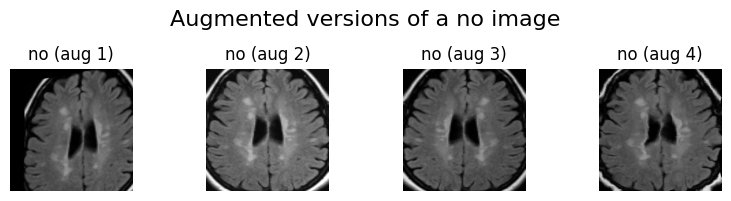

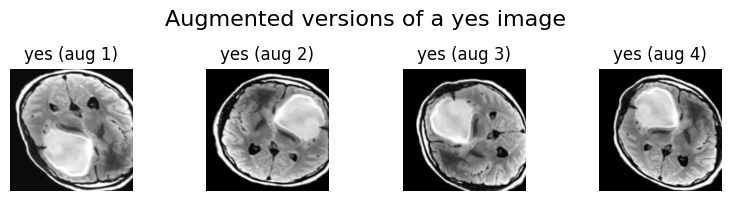

In [22]:
random_no_image = random.choice(no_images)
visualize_augmentations(random_no_image, augmentation_pipeline, num_augmented=4, label='no')

random_yes_image = random.choice(yes_images)
visualize_augmentations(random_yes_image, augmentation_pipeline, num_augmented=4, label='yes')

### Prepare data for training

We apply scaling, define image properties, and set up data generators for efficiently feeding images into the deep learning model.

#### Scaling:
- We scale the image data from **0–255** pixel intensity range to **0–1**.
- This normalization helps the model **train faster** and **generalize better**, as neural networks often perform better when input data is scaled to a consistent range.






In [23]:
# Scale the data to 0-1
X_train_scaled = X_train_cropped / 255
X_val_scaled = X_val_cropped / 255
X_test_scaled = X_test_cropped / 255

In [30]:
# Check
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

1.0
0.0



- `IMG_HEIGHT` and `IMG_WIDTH`: Dimensions to which all images are resized. We use **224x224** pixels to match VGG16’s expected input shape.
- `BATCH_SIZE`: Number of images processed together during each iteration of model training. A batch size of **32** is commonly used.

In [24]:
# Image properties
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Train, val, test folders
train_dir = f'{BASE_DEST}/train_cropped'
val_dir = f'{BASE_DEST}/val_cropped'
test_dir = f'{BASE_DEST}/test_cropped'

####  Data Generators
- `train_generator`: Provides augmented batches of training data.
- `val_generator`: Provides batches of validation data (no augmentation).
- `test_generator`: Provides **individual images** (batch size = 1) with no augmentation for model evaluation or prediction. `shuffle=False` ensures the predictions can be easily matched to the true labels.

In [37]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,  # for evaluation & predictions
    class_mode='binary',
    shuffle=False
)

Found 203 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


## Baseline CNN

We first define a **baseline CNN model** for binary classification of brain MRI images (Tumor vs. No Tumor). This CNN serves as a baseline to evaluate performance before experimenting with more complex architectures.

### Create model

#### Architecture Breakdown:
1. **Input Layer**
   - Accepts input images of shape `224x224x3`.
   
2. **First Convolutional Block**
   - `Conv2D(32, (3, 3), activation='relu')`: Extracts 32 feature maps using a 3x3 filter.
   - `MaxPooling2D(pool_size=(2, 2))`: Reduces spatial dimensions by 2x.

3. **Second Convolutional Block**
   - `Conv2D(64, (3, 3), activation='relu')`: Learns more complex features with 64 filters.
   - `MaxPooling2D(pool_size=(2, 2))`: Further reduces spatial size.

4. **Third Convolutional Block**
   - `Conv2D(128, (3, 3), activation='relu')`: Extracts even deeper features with 128 filters.
   - `MaxPooling2D(pool_size=(2, 2))`: Downsamples the feature maps.

5. **Flatten Layer**
   - Flattens the 3D feature maps into a 1D feature vector.

6. **Fully Connected (Dense) Layers**
   - `Dense(128, activation='relu')`: Learns non-linear combinations of features.
   - `Dropout(0.5)`: Regularization technique to prevent overfitting by randomly dropping 50% of neurons during training.

7. **Output Layer**
   - `Dense(1, activation='sigmoid')`: Outputs a single probability score for **binary classification** (Tumor or No Tumor).


In [38]:
def create_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

In [39]:
# Initialize model
cnn_model = create_cnn_model()

# Compile model
cnn_model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(learning_rate=1e-4))

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train model

Now we train the model.

We also implement **EarlyStopping** that helps prevent **overfitting** during model training. If `val_loss` or stops improving for a specified number of consecutive epochs (`patience`), training is halted early.

In [40]:
EPOCHS = 50

early_stopping = EarlyStopping(patience=5, monitor='val_loss')

history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5876 - loss: 0.6887 - val_accuracy: 0.6154 - val_loss: 0.6658
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.6327 - loss: 0.6637 - val_accuracy: 0.6154 - val_loss: 0.6600
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.5931 - loss: 0.6682 - val_accuracy: 0.6154 - val_loss: 0.6588
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.6129 - loss: 0.6858 - val_accuracy: 0.6154 - val_loss: 0.6553
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 662ms/step - accuracy: 0.5985 - loss: 0.6783 - val_accuracy: 0.6154 - val_loss: 0.6538
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.6876 - loss: 0.6363 - val_accuracy: 0.6154 - val_loss: 0.6468
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.6204 - loss: 0.6472 - val_accuracy: 0.6154 - val_loss: 0.6425
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.6219 - loss: 0.6560 - val_accuracy: 0.6154 - val_loss: 0

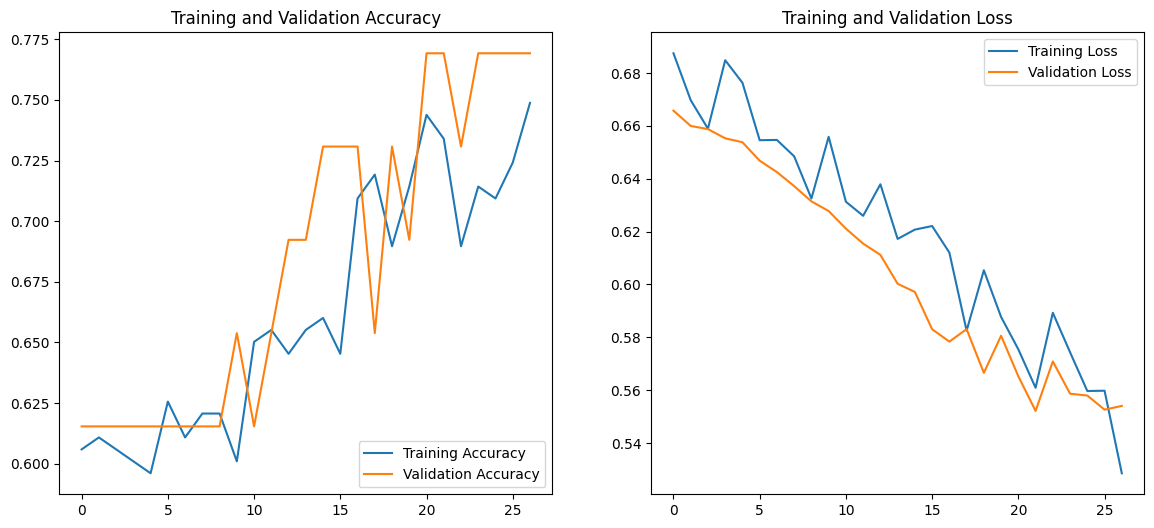

In [41]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot
plot_training_history(history)

### Evaluate model

In [42]:
# Evaluate the trained model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9597 - loss: 0.3807
Test Loss: 0.3924
Test Accuracy: 0.8750


#### Confusion Matrix

We compute the Confusion Matrix, which displays the **true positive**, **true negative**, **false positive**, and **false negative** counts in a matrix format. This gives insight into **how well the model distinguishes** between classes.

We also display the **precision**, **recall**, **f1-score**, and **support** for each class. This helps evaluate both **overall accuracy** and **per-class performance**.

This evaluation helps identify potential issues like **class imbalance**, **misclassifications**, or **bias** in predictions.

In [43]:
def plot_confusion_matrix(model, test_generator, name):
    # Reset the generator before prediction
    test_generator.reset()
    # Predict probabilities
    predictions = model.predict(test_generator)
    # Convert probabilities to class labels (binary classification assumed)
    predicted_classes = (predictions > 0.5).astype('int').ravel()
    # True labels from generator
    true_classes = test_generator.classes
    # Class labels from generator
    class_labels = list(test_generator.class_indices.keys())
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


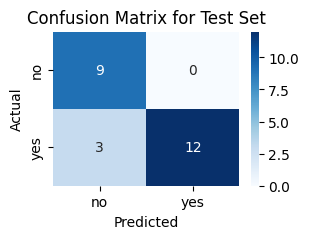

Classification Report:
              precision    recall  f1-score   support

          no       0.75      1.00      0.86         9
         yes       1.00      0.80      0.89        15

    accuracy                           0.88        24
   macro avg       0.88      0.90      0.87        24
weighted avg       0.91      0.88      0.88        24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


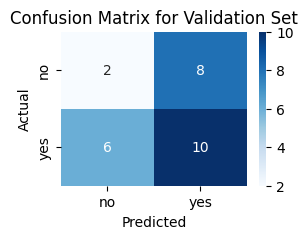

Classification Report:
              precision    recall  f1-score   support

          no       0.25      0.20      0.22        10
         yes       0.56      0.62      0.59        16

    accuracy                           0.46        26
   macro avg       0.40      0.41      0.41        26
weighted avg       0.44      0.46      0.45        26



In [44]:
plot_confusion_matrix(cnn_model, test_generator, name='Test Set')
plot_confusion_matrix(cnn_model, val_generator, name='Validation Set')

In [45]:
# Save the model
cnn_model.save('baseline_model.keras')

## VGG16

**VGG16** is a widely used CNN architecture.

#### Key Features:
- **16 layers deep**, including 13 convolutional layers and 3 fully connected (dense) layers.
- Uses only **3x3 convolutional filters** (the smallest size that captures left/right, up/down, and center information).
- Consistent use of **MaxPooling layers** to reduce spatial dimensions.
- Ends with **fully connected layers** and a **softmax classifier** (when used for multi-class tasks).
- **Pre-trained weights** are available (trained on ImageNet), making VGG16 an excellent backbone for **transfer learning**.

In [46]:
# load base model with pre-trained weights
vgg16_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Visualize feature maps

We can visualize the **feature maps** produced by different **pooling layers** of the VGG16 model.  
This helps us understand how the model processes an input image, transforming raw pixel values into high-level features at various stages of the network.


In [47]:
# Select Pooling Layers to Visualize
layer_names = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']
layer_indices = [3, 6, 10, 14, 18]

# We extract the output feature maps from these layers to observe how features evolve through the network
outputs = [vgg16_base.layers[i].output for i in layer_indices]

# A sub-model created from VGG16, which outputs the feature maps from the specified layers.
feature_map_model = Model(inputs=vgg16_base.input, outputs=outputs)

# Select an input image
sample_image = X_val_cropped[0]

# The image is preprocessed to match the input expectations of VGG16 (scaling and normalization)
img_batch = np.expand_dims(sample_image, axis=0)
img_preprocessed = preprocess_input(img_batch)

# We pass the preprocessed image through the `feature_map_model`
# to get feature maps from each of the selected layers.
# Each feature map shows how different filters respond to various features in the input image.
feature_maps = feature_map_model.predict(img_preprocessed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Feature map shape from layer block1_pool: (1, 112, 112, 64)


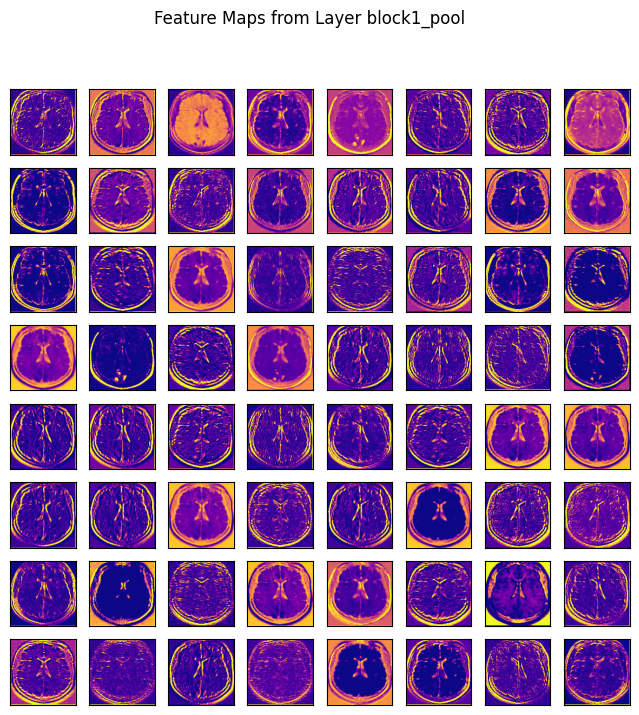

Feature map shape from layer block2_pool: (1, 56, 56, 128)


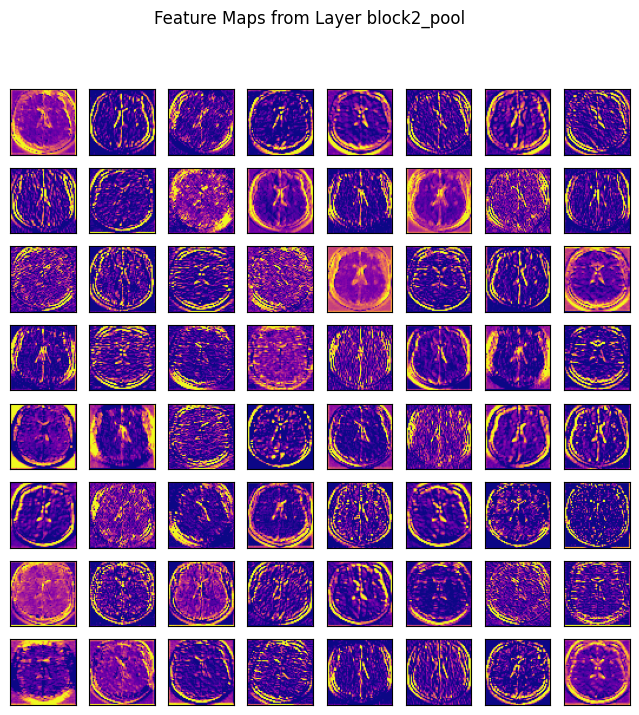

Feature map shape from layer block3_pool: (1, 28, 28, 256)


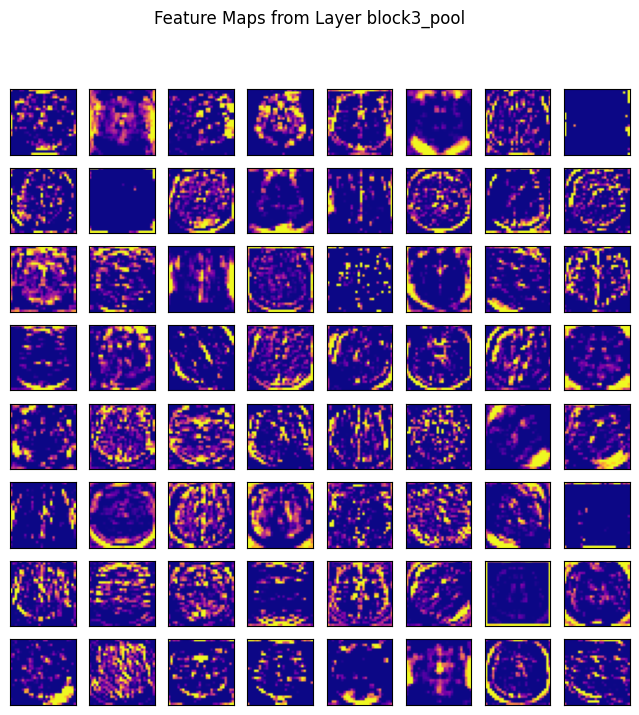

Feature map shape from layer block4_pool: (1, 14, 14, 512)


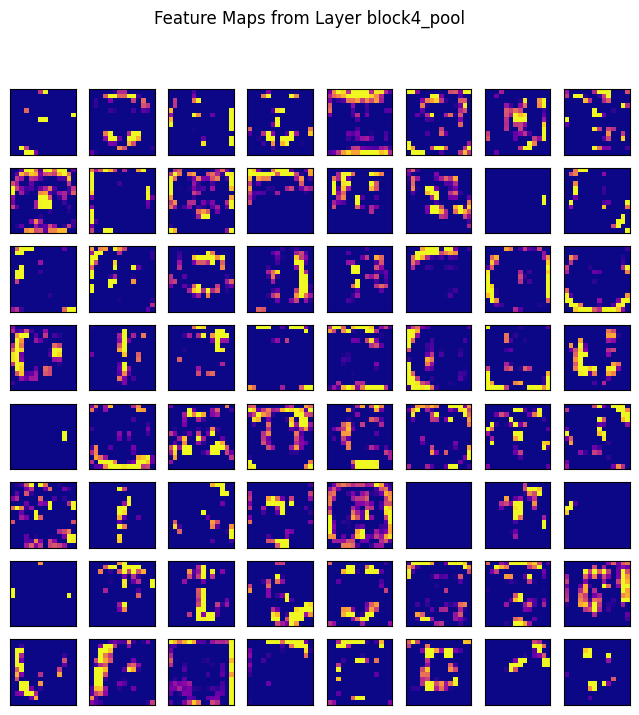

Feature map shape from layer block5_pool: (1, 7, 7, 512)


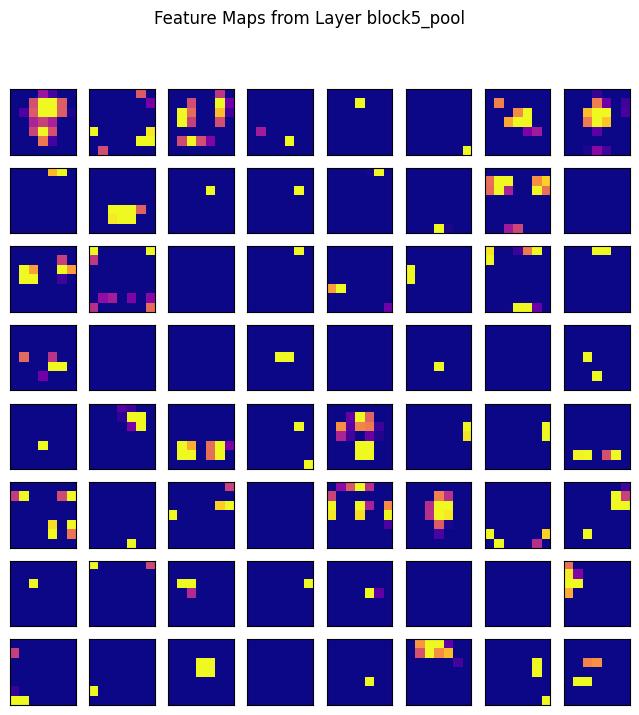

In [48]:
def plot_feature_maps(feature_maps, layer_names=None, max_channels=64):
    for layer_index, fmap in enumerate(feature_maps):
        print(f"Feature map shape from layer {layer_names[layer_index] if layer_names else layer_index}: {fmap.shape}")

        if fmap.ndim == 3:
            fmap = np.expand_dims(fmap, axis=0)

        num_channels = fmap.shape[-1]
        channels_to_display = min(num_channels, max_channels)
        grid_size = int(np.ceil(np.sqrt(channels_to_display)))

        plt.figure(figsize=(8, 8))
        plt.suptitle(f"Feature Maps from Layer {layer_names[layer_index] if layer_names else ''}")

        for i in range(channels_to_display):
            ax = plt.subplot(grid_size, grid_size, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            fmap_channel = fmap[0, :, :, i]

            # Normalize for better visualization
            fmap_channel -= fmap_channel.mean()
            fmap_channel /= (fmap_channel.std() + 1e-6)
            fmap_channel *= 64
            fmap_channel += 128
            fmap_channel = np.clip(fmap_channel, 0, 255).astype('uint8')

            plt.imshow(fmap_channel, cmap='plasma')

        plt.show()

# Call the function to plot each block's feature maps
plot_feature_maps(feature_maps, layer_names)

We can observe how early layers capture simple **edges and textures**. Deeper layers capture more nuanced **shapes, object parts**, and more **abstract patterns**.

### Prepare for transfer Learning

We will freeze all layers except the last 5 so we fine-tune only the deeper layers. This makes training faster and reduces the risk of overfitting when using small datasets.


We use VGG16 in Transfer Learning because it is Pre-trained on ImageNet, and can learn rich feature representations that can be applied to different image tasks.

In [49]:
for layer in vgg16_base.layers[:-5]:
    layer.trainable = False  # freeze early layers
for layer in vgg16_base.layers[-5:]:
    layer.trainable = True   # unfreeze last 5 layers for fine-tuning

Adding custom classification layers on top of VGG16:
- Global Average Pooling instead of Flatten to reduce overfitting and generalize better
- Dense layers to learn new features on top of the pre-trained ones
- Dropout for regularization to prevent overfitting

In [50]:
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)                 # reduces spatial dimensions to a vector
x = Dense(512, activation='relu')(x)            # fully connected layer with ReLU
x = Dropout(0.5)(x)                             # dropout for regularization (50% rate)
predictions = Dense(1, activation='sigmoid')(x) # final binary classification output

In [52]:
# Defining the complete model
# Inputs from the VGG16 base, outputs are predictions from custom layers
vgg16_model = Model(inputs=vgg16_base.input, outputs=predictions)

# Compile the model
vgg16_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),     # low LR to avoid destroying pre-trained weights
    metrics=['accuracy']
)

vgg16_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 7,342,593 (28.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Train model

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = vgg16_model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5215 - loss: 0.7565 - val_accuracy: 0.6154 - val_loss: 0.6644 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 936ms/step - accuracy: 0.6119 - loss: 0.6213 - val_accuracy: 0.6923 - val_loss: 0.6349 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6399 - loss: 0.6267 - val_accuracy: 0.6538 - val_loss: 0.6176 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 691ms/step - accuracy: 0.7178 - loss: 0.5610 - val_accuracy: 0.6538 - val_loss: 0.5869 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.6524 - loss: 0.5770 - val_accuracy: 0.7308 - val_loss: 0.5393 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 552ms/step - accuracy: 0.7693 - loss: 0.5020 - val_accuracy: 0.8077 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.7343 - l

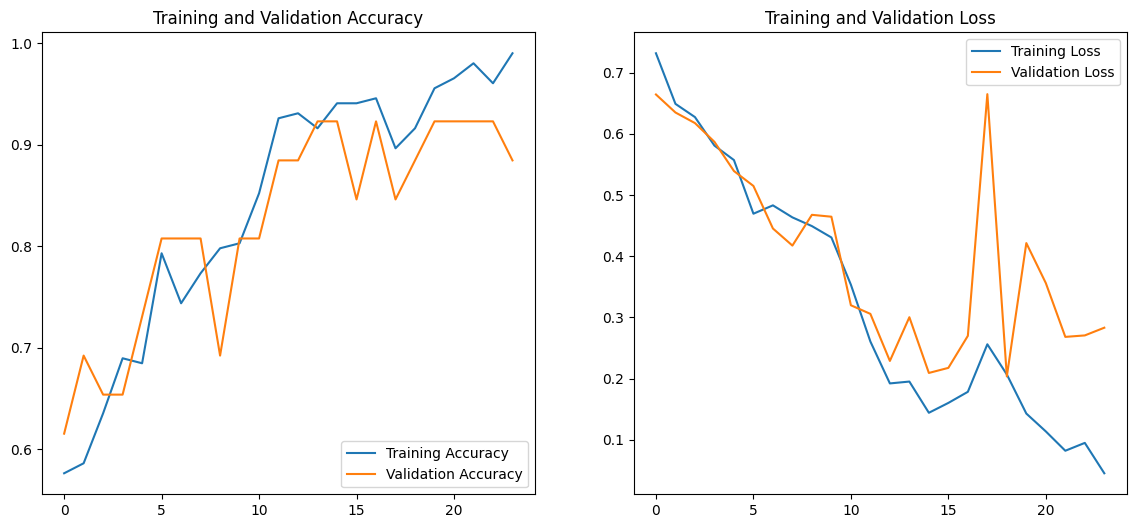

In [54]:
# Plot
plot_training_history(history)

### Evaluate model

In [58]:
# Evaluate
test_loss, test_accuracy = vgg16_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9745 - loss: 0.0898
Test Loss: 0.1175
Test Accuracy: 0.9583


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


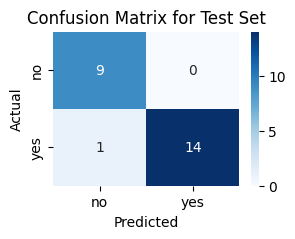

Classification Report:
              precision    recall  f1-score   support

          no       0.90      1.00      0.95         9
         yes       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


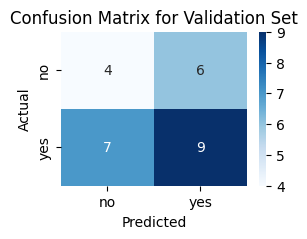

Classification Report:
              precision    recall  f1-score   support

          no       0.36      0.40      0.38        10
         yes       0.60      0.56      0.58        16

    accuracy                           0.50        26
   macro avg       0.48      0.48      0.48        26
weighted avg       0.51      0.50      0.50        26



In [59]:
plot_confusion_matrix(vgg16_model, test_generator, name='Test Set')
plot_confusion_matrix(vgg16_model, val_generator, name='Validation Set')

In [60]:
# Save the model
vgg16_model.save('vgg16_model.keras')

## EfficientNet

**EfficientNet** is a family CNNs that introduced an **efficient scaling method** that uniformly scales all dimensions of a network (depth, width, and resolution) and achieves **state-of-the-art accuracy** on image classification benchmarks while requiring **significantly fewer parameters and computational resources**.

We are using EfficientNetB0, the smallest and most efficient model in the family.



In [61]:
effnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3))

### Prepare for transfer learning

We build a **custom binary classification model** on top of the **EfficientNetB0** base model.  


We **freeze** all layers in the base model to **prevent updating the pre-trained weights** during initial training. This helps retain the **general features** learned from the ImageNet dataset, avoiding overfitting on the small dataset we have.

Custom Classification Head:
- `GlobalAveragePooling2D()`:
  - Reduces the spatial dimensions (H x W) of the feature maps into a **single vector** per feature map.
  - Helps **reduce overfitting** by lowering the number of parameters.
- `Dense(512, activation='relu')`:
  - Fully connected layer with **512 neurons** to learn complex patterns from extracted features.
- `Dropout(0.5)`:
  - Regularization technique to **prevent overfitting** by randomly disabling 50% of the neurons during training.
- `BatchNormalization()`:
  - Normalizes the activations, speeding up training and improving stability.
- `Dense(1, activation='sigmoid')`:
  - Final output layer for **binary classification**, returning a probability between 0 and 1.

In [63]:
# Freeze all layers
for layer in effnet_base.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(effnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Prepare model and compile
effnet_model = Model(inputs=effnet_base.input, outputs=predictions)
effnet_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate=1e-4),
                     metrics=['accuracy'])

### Train model

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = effnet_model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5029 - loss: 0.7840 - val_accuracy: 0.3846 - val_loss: 0.7395 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.5959 - loss: 0.7286 - val_accuracy: 0.3846 - val_loss: 0.7296 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.5675 - loss: 0.7701 - val_accuracy: 0.3846 - val_loss: 0.7278 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.4386 - loss: 0.9014 - val_accuracy: 0.3846 - val_loss: 0.7220 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.5515 - loss: 0.7510 - val_accuracy: 0.3846 - val_loss: 0.7138 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.5419 - loss: 0.7440 - val_accuracy: 0.3846 - val_loss: 0.7087 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 604ms/step - accuracy: 0.4978 - 

In [65]:
# Unfreeze some layers for fine-tuning
for layer in effnet_base.layers[-20:]:
    layer.trainable = True

# Compile again for fine-tuning
effnet_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Continue fine-tuning
effnet_model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.5748 - loss: 0.8866 - val_accuracy: 0.3846 - val_loss: 0.6987 - learning_rate: 1.0000e-05
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.5477 - loss: 0.8591 - val_accuracy: 0.3846 - val_loss: 0.7025 - learning_rate: 1.0000e-05
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.4303 - loss: 0.9943 - val_accuracy: 0.3846 - val_loss: 0.7061 - learning_rate: 1.0000e-05
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.4635 - loss: 0.8575 - val_accuracy: 0.3846 - val_loss: 0.7103 - learning_rate: 1.0000e-05
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.5261 - loss: 0.8991 - val_accuracy: 0.3846 - val_loss: 0.7132 - learning_rate: 1.0000e-05
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - accuracy: 0.4939 - loss: 0.8057 - val_accuracy: 0.3846 - val_loss: 0.7148 - learning_rate: 1.0000e-05


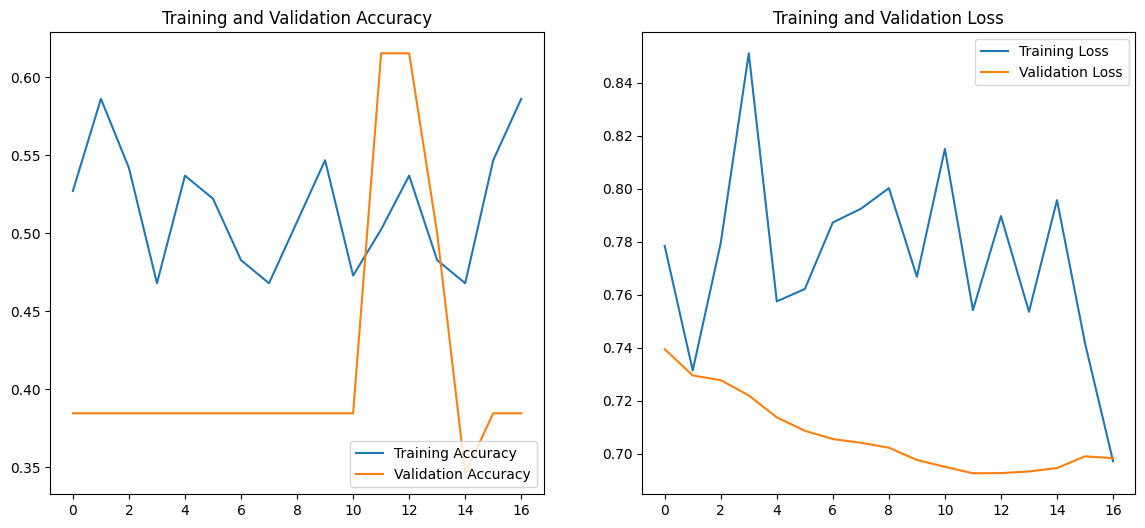

In [66]:
# Plot
plot_training_history(history)

### Evaluate model

In [67]:
# Evaluate
test_loss, test_accuracy = effnet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7159 - loss: 0.6842
Test Loss: 0.6985
Test Accuracy: 0.3750


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


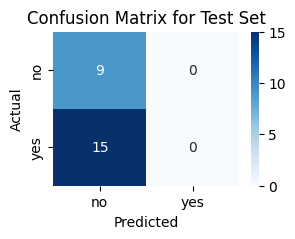

Classification Report:
              precision    recall  f1-score   support

          no       0.38      1.00      0.55         9
         yes       0.00      0.00      0.00        15

    accuracy                           0.38        24
   macro avg       0.19      0.50      0.27        24
weighted avg       0.14      0.38      0.20        24



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


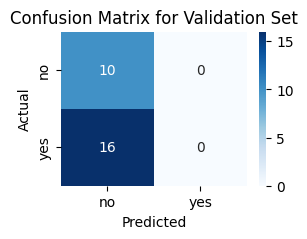

Classification Report:
              precision    recall  f1-score   support

          no       0.38      1.00      0.56        10
         yes       0.00      0.00      0.00        16

    accuracy                           0.38        26
   macro avg       0.19      0.50      0.28        26
weighted avg       0.15      0.38      0.21        26



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
plot_confusion_matrix(effnet_model, test_generator, name='Test Set')
plot_confusion_matrix(effnet_model, val_generator, name='Validation Set')